In [1]:
import matplotlib.pyplot as plt

import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import re
import swifter
from pandarallel import pandarallel

from sklearn import preprocessing, model_selection
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans

import lightgbm as lgbm

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import xgboost as xgb


from surprise import SVD, SVDpp, CoClustering, SlopeOne, KNNBasic, KNNWithZScore
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate as surprise_cv, GridSearchCV as surprise_grid_search_cv, train_test_split as surprise_test_train_split

from settings import file_names
from graph import *
from helpers import *

In [4]:
pandarallel.initialize()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Datasets

In [3]:
df_reviews = pd.read_csv(file_names['toronto_reviews_without_text'])
df_users = pd.read_csv(file_names['toronto_users'])
df_biz = pd.read_csv(file_names['toronto_businesses'])

In [4]:
df_tips = pd.read_json(file_names['tip'], encoding='utf-8', lines=True)
df_tips = df_tips.loc[df_tips['user_id'].isin(df_users.user_id.unique()) & df_tips['business_id'].isin(df_biz.business_id.unique())]
print('Number of Tips: ', df_tips.shape[0])
df_tips.head(3)

Number of Tips:  33192


,user_id,business_id,text,date,compliment_count
7,CaFbX7topxdLpBJ_SNDfGQ,r49iBfbnfoK7yt4rdsL_7g,Hands down best AYCE in town! Love it!,2016-01-05 06:39:33,0
10,8zXgNCkusOHMwh5Tj_8yCQ,qrSsS0pk7SL67MP5nN8tlg,More parking in the back of the restaurant,2013-12-22 05:10:12,0
13,oIHhfloe5VQamDFDB2dr1Q,wZhB4U003eg2GQ-F7D2D4A,When you receive the bag of seafood tie it up ...,2016-08-12 22:18:07,0


In [5]:
print('Number of reviews: ',df_reviews.shape[0])
print('Ratings describe: ', df_reviews['rating'].describe())
df_reviews.head(3)



Number of reviews:  228816
Ratings describe:  count    228816.000000
mean          3.643093
std           1.139687
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


,user_id,business_id,rating,date
0,TpyOT5E16YASd7EWjLQlrw,AakkkTuGZA2KBodKi2_u8A,1.0,2012-07-16 00:37:14
1,_N7Ndn29bpll_961oPeEfw,y-Iw6dZflNix4BdwIyTNGA,3.0,2014-06-27 21:19:23
2,54kpqrxF9DEPpwa51hO_Bw,jzveTy7ogH7cg9axZ78ENg,4.0,2015-04-01 13:31:35


In [6]:
print('Number of users: ',df_users.shape[0])
df_users.head(3)

Number of users:  18804


,user_id,friends
0,gvXtMj3XuPr0xHjgmlmtng,"CfGCj80EdA-xS-mTWlAn4Q, JgD2Rk9K07MkZgG7Nb9YzA..."
1,pU6GoRTcl1rIOi6zMynjog,"SwK2Oo8sjOH0yXYVoyjJwQ, 1LpChUg-0EqRKRKzL4ogYA..."
2,AsYMm_O4H-mwmWbmeACDHw,"w-bVY-dhpvnNs8W3BTTgAA, o_OEO0ES7oywPqENQR0f3A..."


In [7]:
print('Number of businesses: ',df_biz.shape[0])
df_biz.head(3)

Number of businesses:  7965


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
0,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,1170 Queen Street W,Toronto,ON,M6J 1J5,43.642889,-79.425429,3.0,57,"{'WiFi': ""u'no'"", 'BikeParking': 'True', 'Rest...","Juice Bars & Smoothies, Food, Restaurants, Fas..."
1,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,1051 Bloor Street W,Toronto,ON,M6H 1M4,43.660494,-79.432099,3.5,29,"{'BusinessParking': ""{'garage': False, 'street...","Restaurants, Nightlife, Breakfast & Brunch, Ve..."
2,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,582 College Street,Toronto,ON,M6G 1B3,43.655420,-79.413352,4.0,9,"{'Alcohol': ""u'full_bar'"", 'Caters': 'False', ...","Restaurants, Breakfast & Brunch, Bars, Modern ..."


# Collaborative Filtering - Rating Prediction

In [8]:
df_surprise = df_reviews[['business_id', 'user_id', 'rating']]
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_surprise, reader)
algo = SVD()

# surprise_cv(algo, data, measures=['RMSE', 'MAE', 'fcp'], cv=3, verbose=3, n_jobs=3)

In [9]:
trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

FCP:  0.5817
MAE:  0.8160
0.5817258119417782 0.8159765577951598


In [10]:
predictions[:2]

[Prediction(uid='Ibp4hEKSE8JaX9OvfEiFqg', iid='z4PBmnPcQnjB92Jyd9CRZw', r_ui=4.0, est=3.937923755755479, details={'was_impossible': False}),
 Prediction(uid='TrOgTZ0DfmQxvpTehiNibQ', iid='b4Dvi7D0LkrJcyzEsP0w4A', r_ui=3.0, est=3.2053490850018918, details={'was_impossible': False})]

# Baseline Binary Prediction - Collaborative Filtering

#### Build input data for recommender:

In [11]:
from networkx.algorithms import bipartite
from graph import *

g_bi = make_user_business_bipartite_graph(weighted=False, minimum_rating=0)

In [12]:
users = {n for n, d in g_bi.nodes(data=True) if d['bipartite']==0}
businesses = set(g_bi) - users
print(len(users), len(businesses), len(set(g_bi)))

18802 7860 26662


In [13]:
def get_binary_df(graph):
    df_users = pd.read_csv(file_names['toronto_users'])
    
    users = {n for n, d in graph.nodes(data=True) if d['bipartite']==0}
    businesses = set(graph) - users
    
    binary_data = bipartite.biadjacency_matrix(graph, users, column_order=businesses).todense()
    df_binary = pd.DataFrame(binary_data, columns=businesses)
    df_binary['user_id'] = users
    df_binary = pd.melt(df_binary, id_vars='user_id')
    df_binary.rename({'variable':'business_id', 'value':'has_reviewed'}, axis='columns', inplace=True)
    # df_binary.set_index(list(graph.nodes()))
    return df_binary

In [14]:
df_binary = get_binary_df(g_bi)

In [15]:
def negative_sampling(df, ratio_zeros_on_ones : float):
    '''
    creates a dataframe for training of recommender. 
    Only keeps a fractions of non-positive labels, as input matrix is extremely sparse.
    params: 
    df: pd.DataFrame containing user_id, business_id, and binary label has_reviewed
    '''
    df_zeros = df_binary.loc[df_binary['has_reviewed'] == 0]
    df_ones = df_binary.loc[df_binary['has_reviewed'] != 0]
    df_zeros = df_zeros.sample(n=int(df_ones.shape[0]*ratio_zeros_on_ones))
    return pd.concat([df_zeros, df_ones]).sample(frac=1).reset_index(drop=True)

#### Build, train and evaluate recommender:

In [16]:
reader = Reader(rating_scale=(0, 1))

data = negative_sampling(df_binary, 1)
print(data.shape)
data = Dataset.load_from_df(data, reader)

algo = SVDpp(n_factors=10, n_epochs=30, init_mean=0.5)

trainset, testset = surprise_test_train_split(data, test_size=.25)
algo.fit(trainset)

predictions = algo.test(testset)
print(accuracy.fcp(predictions, verbose=True), accuracy.mae(predictions, verbose=True))

(441858, 3)
FCP:  0.6837
MAE:  0.2832
0.6836937381881599 0.2831582575101775


#### Precision of the recommender: Percentage of Top 1 recommendation that actually corresponds to a visit

In [17]:
from helpers import get_top_n

top_pred = get_top_n(predictions, n=1)
user_ids = list(top_pred.keys())
business_ids = [top_pred[0][0] for top_pred in list(top_pred.values())]

df_top_pred_test = pd.DataFrame({'user_id':user_ids, 'business_id':business_ids})

df_top_pred_test = pd.merge(df_top_pred_test,df_binary, how='left', on=['user_id','business_id'])
df_top_pred_test.head(3)

,user_id,business_id,has_reviewed
0,ilQkapV_zMQlwZRbk8lx1Q,eMTE-wqpk_YWaV3mf7Ii3A,0
1,E7Zdnb-4v1RTiLysJqWxDQ,kOFDVcnj-8fd3doIpCQ06A,1
2,TOexoXiiTWyhJ76UfJ1J5w,7Cm5SCTu7LePBCXTUaEiwQ,1


In [18]:
print('precision of top 1 recommender: {}'.format(df_top_pred_test['has_reviewed'].mean()))
print('Note that a random recommender would have a precision of : {}'.format(df_binary['has_reviewed'].mean()))

precision of top 1 recommender: 0.5868790496760259
Note that a random recommender would have a precision of : 0.0014949481580244428


# Binary Prediction - Using Graph Analysis
- Community detection
    - User --[Friends]-->User
        - and build features: percentage of user from this cluster who went to each restaurant, size of cluster
    - User --[Reviewed]-->Restaurant
        - and build features: is_in_same_cluster, distance between clusters
    - User --[Friends]-->User & User --[Reviewed]-->Restaurant   (and build features: is_in_same_cluster, distance between clusters)
        - idem
    - User --[distance with reviewed restaurant using geolocalisation]-->Reastaurant
        - idem
- Centrality measures on restaurants


### Train, Test & Validation Data

In [31]:
data = {}
for mode in ['train', 'test', 'validation']:
    data[mode] = pd.read_csv('Exp Results/binary_{}.csv'.format(mode), index_col=0)

In [32]:
for key in data.keys():
    print(key,data[key].shape,'\n',data[key].head(3),'\n\n')

train (309520, 3) 
                   user_id             business_id  has_reviewed
0  9qzllzNbQZcok-NbvqfL3g  aObwBM6rLOd9gbj36ghwzA             0
1  cdod5prmr9N46OByHpDkOw  4_EgrMY-EI-i-xyWixI2qg             1
2  M47qaopiiCOI2BrSH8Vvow  wuYKpHyjIfyvMR9YlwHn6Q             1 


test (67290, 3) 
                   user_id             business_id  has_reviewed
0  OEGQGXcPW5HMrxI7qpBrkg  ZCdXbef51G3yyjVEXB7AYw             0
1  3Ml2JhGnCWjb3Migca1O4A  Njc2gHb5Z_ufkA_ow7hKqw             1
2  t21OyjIVoBMRmCIaElwuEQ  cRuk2y-LeWL42UVEkLVU3A             1 


validation (67674, 3) 
                   user_id             business_id  has_reviewed
0  oHT16085laukiKm7-kpUFQ  87I8ba2FKYKeXyAhiC6cLg             0
1  Cj_z5Ru9BHA-rT6GWuzSbQ  sKrt4CMGyG8YAjxVkk4hPQ             1
2  uCdmtWpEku3xLa-ScQabKA  eISyaSdeTWQA2z9k-r_F4Q             0 




### Recommender

In [33]:
for key in data.keys():
    data[key] = pd.read_csv('Exp Results/binary_and_reco_{}.csv'.format(key), index_col=0)
data['train'].head(3)

,user_id,business_id,has_reviewed,reco
0,9qzllzNbQZcok-NbvqfL3g,aObwBM6rLOd9gbj36ghwzA,0,0.390040
1,cdod5prmr9N46OByHpDkOw,4_EgrMY-EI-i-xyWixI2qg,1,0.753829
2,M47qaopiiCOI2BrSH8Vvow,wuYKpHyjIfyvMR9YlwHn6Q,1,0.624466


### Friends Graph

#### Clustering

In [34]:
for key in data.keys():
    data[key] = pd.read_csv('Exp Results/binary_and_infomap_{}.csv'.format(key), index_col=0)
print('train data: ','\n')
data['train'].head(3)

train data:  



,user_id,business_id,has_reviewed,reco,user_infomap_friends
0,9qzllzNbQZcok-NbvqfL3g,aObwBM6rLOd9gbj36ghwzA,0,0.390040,2290
1,cdod5prmr9N46OByHpDkOw,4_EgrMY-EI-i-xyWixI2qg,1,0.753829,1615
2,M47qaopiiCOI2BrSH8Vvow,wuYKpHyjIfyvMR9YlwHn6Q,1,0.624466,2247


nb_users:  18801
nb_communities:  5930


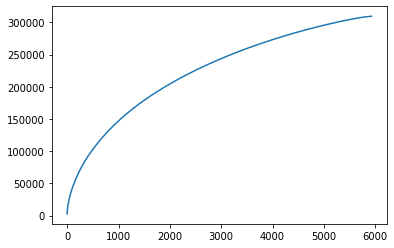

In [35]:
df_infomap_friends = data['train']
print('nb_users: ',len(df_infomap_friends['user_id'].unique()))
print('nb_communities: ',len(df_infomap_friends['user_infomap_friends'].unique()))

plt.plot(np.cumsum(sorted(df_infomap_friends.groupby(by='user_infomap_friends').count()['user_id'].values, reverse = True)))

#### Features

In [36]:
data['train'].head(3)

,user_id,business_id,has_reviewed,reco,user_infomap_friends
0,9qzllzNbQZcok-NbvqfL3g,aObwBM6rLOd9gbj36ghwzA,0,0.390040,2290
1,cdod5prmr9N46OByHpDkOw,4_EgrMY-EI-i-xyWixI2qg,1,0.753829,1615
2,M47qaopiiCOI2BrSH8Vvow,wuYKpHyjIfyvMR9YlwHn6Q,1,0.624466,2247


In [37]:
def get_proportion_of_restaurant_reviewers_in_community(df_train, community_name):
    df = df_train.copy()
    
    community_size = round(df.groupby(by=[community_name], as_index=False)['user_id'].count() / 50) * 5
    community_size.rename({'user_id':'size_{}'.format(community_name)}, inplace=True, axis=1)
    community_size[community_name] = community_size.index.values


    restaurant_reviewers = df.loc[df['has_reviewed']==1].groupby(by=[community_name,'business_id'], as_index=False)['reco'].count()
    df = pd.merge(restaurant_reviewers, community_size, how='left')
    df['proportion_{}'.format(community_name)] = round(10 * df['reco'] / (df['size_{}'.format(community_name)]+1)) / 10
    community_proportions = df[[community_name, 'business_id', 'proportion_{}'.format(community_name)]].fillna(0)
    
    return community_size, community_proportions

In [38]:
community_size, community_proportions = get_proportion_of_restaurant_reviewers_in_community(data['train'], 'user_infomap_friends')

features = pd.merge(community_proportions, community_size, how = 'left', on = ['user_infomap_friends']).fillna(0)

for key in data.keys():
    data[key] = pd.merge(data[key], features, how = 'left', on = ['user_infomap_friends','business_id']).fillna(0)

In [39]:
data['train'].head(3)

,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends
0,9qzllzNbQZcok-NbvqfL3g,aObwBM6rLOd9gbj36ghwzA,0,0.390040,2290,0.0,0.0
1,cdod5prmr9N46OByHpDkOw,4_EgrMY-EI-i-xyWixI2qg,1,0.753829,1615,0.2,5.0
2,M47qaopiiCOI2BrSH8Vvow,wuYKpHyjIfyvMR9YlwHn6Q,1,0.624466,2247,0.2,5.0


In [40]:
Counter(data['train']['size_user_infomap_friends'])

Counter({0.0: 161268,
         5.0: 52042,
         20.0: 14019,
         35.0: 2918,
         50.0: 1668,
         25.0: 7203,
         10.0: 34893,
         15.0: 17490,
         60.0: 643,
         45.0: 1934,
         110.0: 1039,
         245.0: 1646,
         105.0: 768,
         30.0: 3994,
         65.0: 356,
         90.0: 513,
         40.0: 3189,
         70.0: 258,
         80.0: 492,
         145.0: 830,
         265.0: 1409,
         55.0: 462,
         100.0: 486})

#### Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [42]:
clf = LogisticRegression()

X_train = data['train'][['reco']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['reco']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),'\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.11959808736107522 
test_mae:  0.4057958091841284


In [43]:
clf.predict(X_train)

array([0, 1, 1, ..., 0, 1, 0])

In [44]:
clf = LogisticRegression()

X_train = data['train'][['size_user_infomap_friends','proportion_user_infomap_friends']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['size_user_infomap_friends','proportion_user_infomap_friends']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),
      '\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.0032146549495993795 
test_mae:  0.4890622677961064


### Full Graph

In [46]:
for key in data.keys():
    data[key] = pd.read_csv('Exp Results/binary_and_infomap_full_weight_ratio2{}.csv'.format(key), index_col=0)
print('train data','\n')
data['train'].head(3)

train data 



,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends,user_infomap_full,business_infomap_full
0,9qzllzNbQZcok-NbvqfL3g,aObwBM6rLOd9gbj36ghwzA,0,0.390040,2290,0.0,0.0,0,807
1,cdod5prmr9N46OByHpDkOw,4_EgrMY-EI-i-xyWixI2qg,1,0.753829,1615,0.2,5.0,0,0
2,M47qaopiiCOI2BrSH8Vvow,wuYKpHyjIfyvMR9YlwHn6Q,1,0.624466,2247,0.2,5.0,22,188


nb_users:  18801
nb_communities:  983


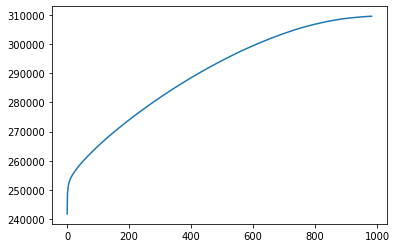

In [49]:
df_infomap_full = data['train']
print('nb_users: ',len(df_infomap_full['user_id'].unique()))
print('nb_communities: ',len(df_infomap_full['user_infomap_full'].unique()))

plt.plot(np.cumsum(sorted(df_infomap_full.groupby(by='user_infomap_full').count()['user_id'].values, reverse = True)))

In [50]:
data['train'].head(3)

,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends,user_infomap_full,business_infomap_full
0,9qzllzNbQZcok-NbvqfL3g,aObwBM6rLOd9gbj36ghwzA,0,0.390040,2290,0.0,0.0,0,807
1,cdod5prmr9N46OByHpDkOw,4_EgrMY-EI-i-xyWixI2qg,1,0.753829,1615,0.2,5.0,0,0
2,M47qaopiiCOI2BrSH8Vvow,wuYKpHyjIfyvMR9YlwHn6Q,1,0.624466,2247,0.2,5.0,22,188


In [56]:
for key in data.keys():
    data[key]['infomap_full_indicator'] = (data[key]['business_infomap_full'] == data[key]['user_infomap_full']) * 1
    data[key].drop(['business_infomap_full','user_infomap_full'], axis=1, inplace=True)
print('train data','\n')
data['train'].head(3)

train data 



,user_id,business_id,has_reviewed,reco,user_infomap_friends,proportion_user_infomap_friends,size_user_infomap_friends,infomap_full_indicator
0,9qzllzNbQZcok-NbvqfL3g,aObwBM6rLOd9gbj36ghwzA,0,0.390040,2290,0.0,0.0,0
1,cdod5prmr9N46OByHpDkOw,4_EgrMY-EI-i-xyWixI2qg,1,0.753829,1615,0.2,5.0,1
2,M47qaopiiCOI2BrSH8Vvow,wuYKpHyjIfyvMR9YlwHn6Q,1,0.624466,2247,0.2,5.0,0


In [58]:
Counter(data['train']['infomap_full_indicator'])

Counter({0: 111320, 1: 198200})

### Classifier using full graph features only

In [59]:
clf = LogisticRegression()

X_train = data['train'][['infomap_full_indicator']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['infomap_full_indicator']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),
      '\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.29277591108813644 
test_mae:  0.29747362163768765


### Classifier using friends graph & full graph features & reco

In [48]:
clf = LogisticRegression()

X_train = data['train'][['reco','size_infomap_friends','proportion_infomap_friends','size_infomap_full','proportion_infomap_full']].values
y_train = data['train']['has_reviewed'].values

X_test = data['test'][['reco','size_infomap_friends','proportion_infomap_friends','size_infomap_full','proportion_infomap_full']].values
y_test = data['test']['has_reviewed'].values

clf.fit(X_train, y_train)
print('train_mae: ',mean_absolute_error(clf.predict(X_train), y_train),
      '\ntest_mae: ', mean_absolute_error(clf.predict(X_test), y_test))

train_mae:  0.036359524424916 
test_mae:  0.4319958389062268


# Future Work

### Use a different train/evaluation method.
For a recommender, use more a leave one out like approach.  
With our current approach, we will never suggest a restaurant that open this year, which is a huge problem.

### Use coordinates
Could be used to build a graph or relevant features

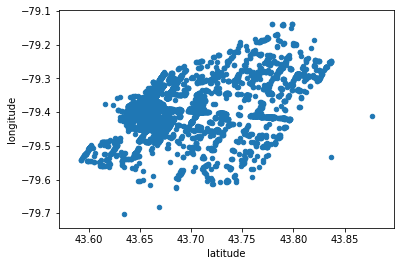

In [41]:
coordinates = df_biz[['latitude', 'longitude']]
coordinates.plot.scatter('latitude','longitude')

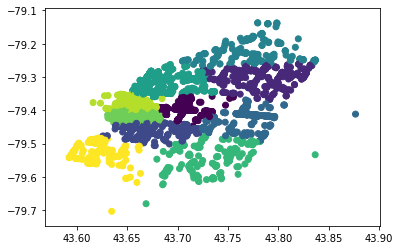

In [42]:
clf = KMeans(n_clusters=10)
clf.fit(coordinates)
coordinates_clusters = clf.labels_
plt.scatter(x = coordinates['latitude'], y = coordinates['longitude'], c=coordinates_clusters)